In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import anndata

In [2]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [25]:
# read in CellRanger output data

folders = ["CID005217-1", "CID005221-1", "CID006493-1", "CID006515-1", "CID007664-1", "CID007827-1", "CID008474-1"]
adata_list = []

# read sample
for sample in folders:
    
        #sample = folders[0]
        path = 'C:/Users/saman/00_Bachelorarbeit/Bachelor/data/' + sample + '/filtered/' # TODO: change to universal path here
        adata = sc.read_mtx(
                filename= (path + 'matrix.mtx'),  # the .mtx file 
        )
        adata = adata.transpose()

        # obs = single cells and their barcodes (2312)
        # var = genes and their annotations (33808)

        adata.obs['sampleID'] = sample
        adata.obs['barcode'] = pd.read_csv((path + 'barcodes.tsv'), delimiter='\t', names=['barcode']).values
        adata.var = pd.read_csv((path + 'features.tsv'), delimiter='\t', names=['gene_ids', 'index', 'feature_types'], index_col='index')
        adata.var_names_make_unique()
        adata.obs_names_make_unique()

        adata_list.append(adata)
        print(sample + " done")


CID005217-1 done
CID005221-1 done
CID006493-1 done
CID006515-1 done
CID007664-1 done
CID007827-1 done
CID008474-1 done


In [26]:
adata_list[0].var

,gene_ids,feature_types
index,,
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression


## SoupX 

In [7]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [9]:
del adata_pp

In [10]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [ ]:
raw_path = '../data/qc_data/' + sample + '/Gene/raw'
adata_raw = sc.read_10x_mtx(
    path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

In [ ]:
# do SoupX ambient RNA removal here

## Doublet Detection

In [7]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [27]:
for sample in range(len(adata_list)):
    data_mat = adata_list[sample].X.T
    %R -i data_mat
    %R set.seed(123)
    %R sce = scDblFinder(SingleCellExperiment(list(counts = data_mat), ))
    %R doublet_score = sce$scDblFinder.score
    doublet_score = ro.globalenv['doublet_score']
    #print(doublet_score)
    adata_list[sample].obs['doublet_score'] = doublet_score

adata_list[0].obs.columns

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not

Index(['sampleID', 'barcode', 'doublet_score'], dtype='object')

## Calculation of QC metrics per sample

In [28]:
# outlier threshold definition
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    lower = np.median(M) - nmads * (M - M.mean()).abs().mean()
    upper = np.median(M) + nmads * (M - M.mean()).abs().mean()
    outlier = (M < lower) | (upper < M)
    return outlier, lower, upper


def all_qc_metrics(adata):

    metrics = {}
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    # calculate QC metrics now

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) #TODO: do we want log1p here?

# TODO: PLOTS FOR EACH SAMPLE BEFORE CORRECTING QC !!!
# TODO: remove high value outliers? 0.995 upper percentile
    
    # filter outliers 
    tc_outliers, metrics['tc_lower'], metrics['tc_upper'] = is_outlier(adata, "log1p_total_counts", 5)
    ng_outliers, metrics['ng_lower'], metrics['ng_upper'] = is_outlier(adata, "log1p_n_genes_by_counts", 5)
    top20_outliers, metrics['top20_lower'], metrics['top20_upper'] = is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    adata.obs["outlier"] = (tc_outliers | ng_outliers | top20_outliers)
    
    temp_cell = 0
    if (len(adata.obs.outlier.value_counts()) > 1):
        temp_cell = adata.obs.outlier.value_counts()[1]
    metrics['n_cell_outlier'] = temp_cell

    # filter out high mitochondrial percent cells
    mt_outlier, metrics['mt_lower'], metrics['mt_upper'] = is_outlier(adata, "pct_counts_mt", 3) 
    adata.obs["mt_outlier"] = mt_outlier | ( adata.obs["pct_counts_mt"] > 25) # adjusable value, 25 is permissable

    temp_mt = 0
    if (len(adata.obs.mt_outlier.value_counts()) > 1):
        temp_mt = adata.obs.mt_outlier.value_counts()[1]
    metrics['n_mt_outliers'] = temp_mt

    # summary of removed cells
    metrics['n_cells_before'] = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    metrics['n_cells_after'] = adata.n_obs

    # filter out low count genes
    metrics['n_genes_before'] = adata.n_vars
    # Min 20 cells - filters out 0 count genes
    sc.pp.filter_genes(adata, min_cells=20)
    metrics['n_genes_after'] = adata.n_vars

    return adata, metrics

In [ ]:
list_metrics = []
adatas_qced = []

for sample in adata_list:
    adata, metric = all_qc_metrics(sample)
    list_metrics.append(list(pd.Series(metric.values())))
    adatas_qced.append(adata)

In [37]:
df_metrics = pd.DataFrame(data = list_metrics, columns = ["tc_lower", "tc_upper", "ng_lower", "ng_upper", "top20_lower", "top20_upper", "n_cell_outlier", "mt_lower", "mt_upper", "n_mt_outliers",
    "n_cells_before", "n_cells_after", "n_genes_before", "n_genes_after"], index=folders)

df_metrics

# LOOK INTO SAMPLE 5221

,tc_lower,tc_upper,ng_lower,ng_upper,top20_lower,top20_upper,n_cell_outlier,mt_lower,mt_upper,n_mt_outliers,n_cells_before,n_cells_after,n_genes_before,n_genes_after
CID005217-1,6.614544,11.930395,5.153028,10.645279,-39.918747,130.192890,45.0,-14.458876,91.659132,477.0,2312.0,477.0,33808.0,11669.0
CID005221-1,5.376746,9.194267,-1.273096,8.325817,48.173741,150.224428,422.0,54.580342,131.275172,0.0,10359.0,0.0,33808.0,0.0
CID006493-1,6.497736,10.489908,3.479385,11.082009,-93.935042,152.512547,28.0,-69.821949,96.777821,873.0,2452.0,1561.0,33808.0,13328.0
CID006515-1,6.067164,11.687042,5.648118,9.682451,-41.550147,89.571512,24.0,-30.417998,52.925185,437.0,1695.0,1258.0,33808.0,13204.0
CID007664-1,6.560970,11.557833,4.666738,10.319897,-44.704622,149.345590,40.0,-47.412933,82.189301,832.0,2273.0,1441.0,33808.0,13546.0
CID007827-1,6.957418,12.123309,5.132477,10.394416,-62.583230,145.885736,7.0,-37.027208,63.453943,269.0,949.0,680.0,33808.0,12708.0
CID008474-1,7.345757,11.812387,5.756858,10.314995,-54.654893,121.473950,5.0,-21.757519,56.526844,1029.0,3253.0,2224.0,33808.0,14947.0


In [36]:
# concat all sample anndata objects into one
adata = anndata.concat(adatas_qced)
adata.obs

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,sampleID,barcode,doublet_score,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier
11,CID005217-1,AAAGGTAAGAGTCAGC,0.054189,1975,7.588830,4910.0,8.499233,25.641548,947.0,6.854354,19.287169,901.0,6.804615,18.350306,0.0,0.000000,0.000000,False,False
20,CID005217-1,AAAGTCCTCGAACGGA,0.170773,3156,8.057377,12075.0,9.398975,23.892340,2034.0,7.618251,16.844721,2595.0,7.861727,21.490683,1.0,0.693147,0.008282,False,False
32,CID005217-1,AACAGGGAGTATTGCC,0.011595,2239,7.714231,5180.0,8.552753,24.652510,882.0,6.783325,17.027027,456.0,6.124683,8.803089,1.0,0.693147,0.019305,False,False
33,CID005217-1,AACAGGGGTGAATGAT,0.036990,1800,7.496097,4670.0,8.449128,25.074946,422.0,6.047372,9.036403,553.0,6.317165,11.841541,1.0,0.693147,0.021413,False,False
37,CID005217-1,AACCAACGTCATCGCG,0.031200,2651,7.883069,7685.0,8.947156,17.748861,578.0,6.361302,7.521145,1039.0,6.946976,13.519844,0.0,0.000000,0.000000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3247,CID008474-1,TTTGGTTTCCGAACGC,0.582567,6812,8.826588,45363.0,10.722474,21.438176,5960.0,8.692993,13.138461,7780.0,8.959440,17.150541,8.0,2.197225,0.017636,False,False
3248,CID008474-1,TTTGGTTTCTGCGGGT,0.949638,6161,8.726157,30556.0,10.327349,27.061788,6070.0,8.711279,19.865166,5906.0,8.683893,19.328447,4.0,1.609438,0.013091,False,False
3249,CID008474-1,TTTGTTGAGTTACTCG,0.415578,5318,8.579041,27492.0,10.221686,21.737233,4422.0,8.394573,16.084679,5032.0,8.523771,18.303507,3.0,1.386294,0.010912,False,False
3251,CID008474-1,TTTGTTGCATGAGTAA,0.018150,994,6.902743,7282.0,8.893298,74.430102,204.0,5.323010,2.801428,379.0,5.940171,5.204614,1.0,0.693147,0.013732,False,False


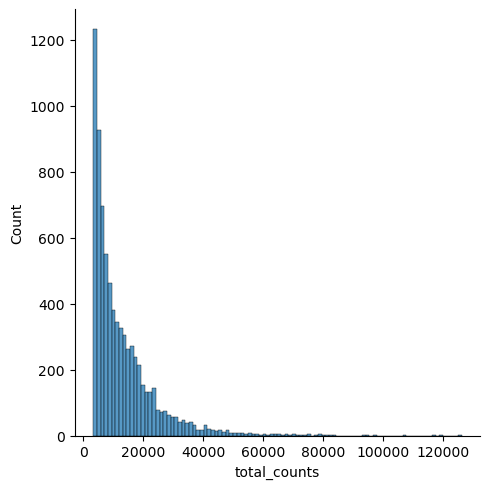

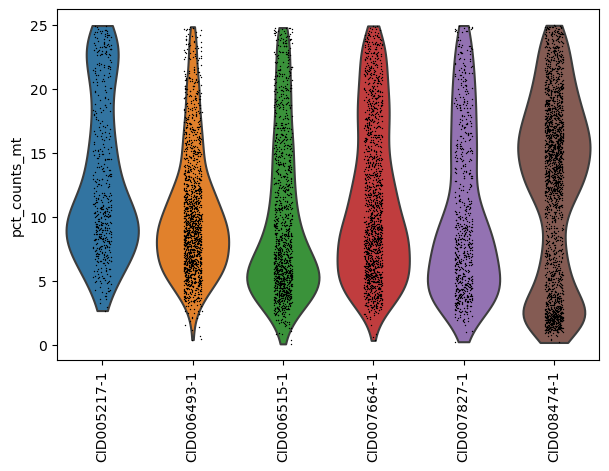

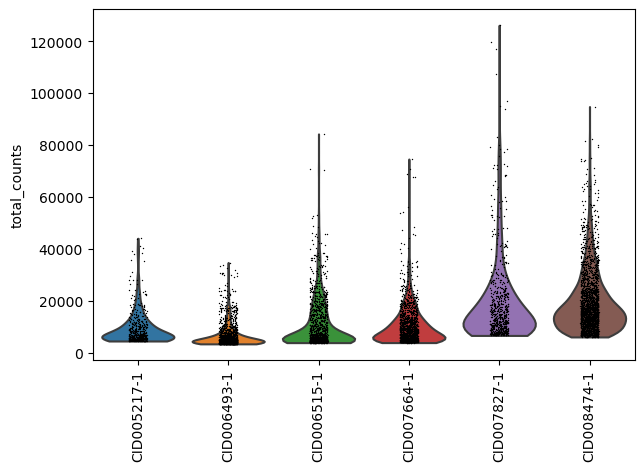

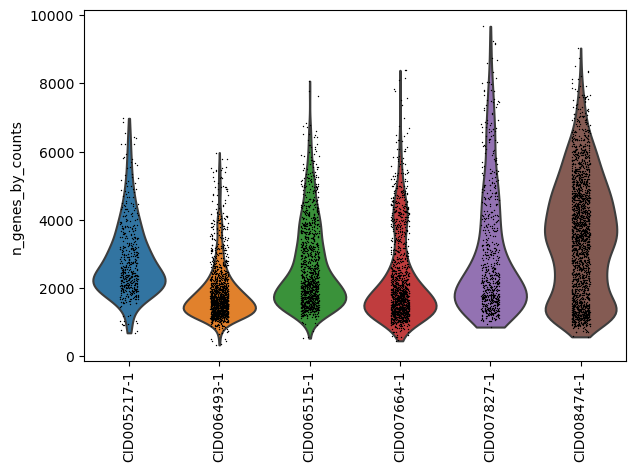

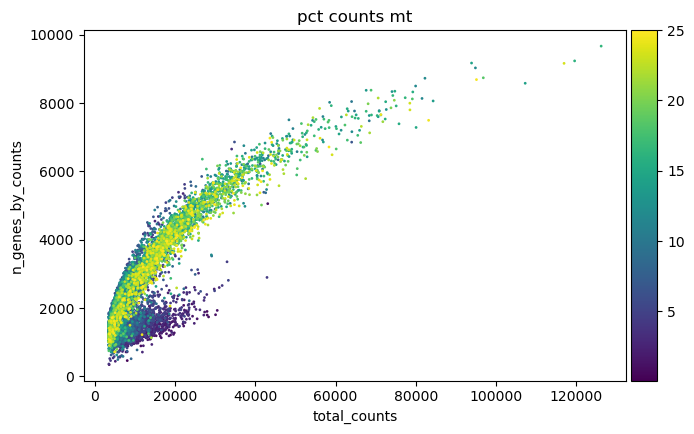

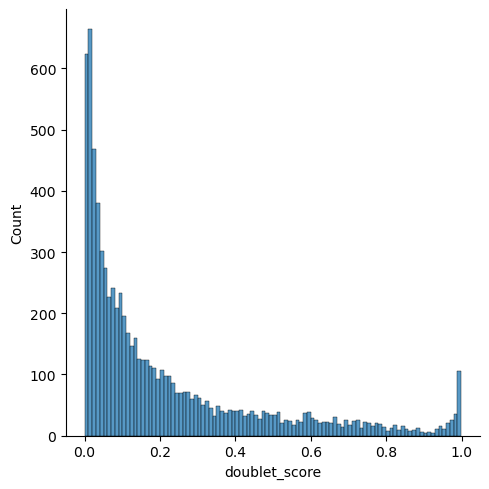

In [33]:
# plotting QC metrics AFTER QC CORRECTION ON EACH SAMPLE INDIVIDUALLY

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt", groupby= "sampleID", rotation=90)
p3 = sc.pl.violin(adata, "total_counts", groupby= "sampleID", rotation=90)
p4 = sc.pl.violin(adata, "n_genes_by_counts", groupby= "sampleID", rotation=90)
p5 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p6 = sns.displot(adata.obs["doublet_score"], bins=100, kde=False)

## TC Normalization